# 1. Required libraries

In [ ]:
# core libraries
import numpy as np
import pandas as pd

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import plotly.express as px
import plotly

# clustering methods
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS

# libraries for data preparation
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer, FunctionTransformer, OneHotEncoder

# metrics
from sklearn.metrics import calinski_harabasz_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, silhouette_samples

# supportive libraries
from scipy.cluster.hierarchy import dendrogram
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tqdm.notebook import tqdm as tqdm
import itertools


# 2. Visualization configurations


In [ ]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['figure.facecolor'] = 'white'

plt.style.use('seaborn-white')

# 3. Installing data

In [ ]:
!pip install bds_courseware
from bds_courseware import read_drive_dataset
from bds_courseware import print_dataset_description, print_module_datasets
from bds_courseware import HOMEWORK_DATASETS

print("Dataset names: ", HOMEWORK_DATASETS.keys())
name = "quake"
df = read_drive_dataset(*HOMEWORK_DATASETS[name])
print(df.head(2))
print(df.shape)

Dataset names:  dict_keys(['suicide_rates', 'car_perfs', 'brain', 'bank', 'air_quality', 'hypothyroid', 'movies', 'bike_sharing_day', 'bike_sharing_hour', 'quake'])
   Focal depth  Latitude  Longitude  Richter
0           33    -52.26      28.30      6.7
1           36     45.53     150.93      5.8
(2178, 4)


#  4. EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Focal depth  2178 non-null   int64  
 1   Latitude     2178 non-null   float64
 2   Longitude    2178 non-null   float64
 3   Richter      2178 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 68.2 KB


Let's take a look at the distributions of features. It is important to scale data before clustering, because clustering algorithms use distance. So, we need to analyse histograms and try to understand, what approaches to use on the stage of data preparation.

## Features distribution analysis

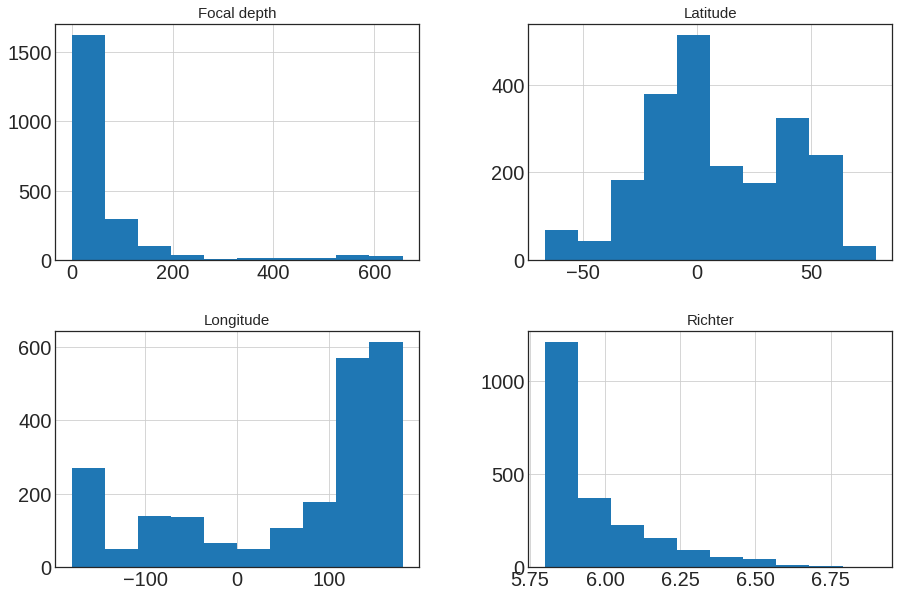

In [ ]:
df.hist(figsize=(15, 10));

Some insights:
* Firsly, features have different scales;

* Focal depth and Richter features are skewed;

* It seems, that most of the provided earthquakes have low Richter and low Focal depth;

* There are coordinates in our data. We will decide what to do with them later.



Let's check the number of unique values of provided features.

In [ ]:
for feature in df.columns:
  print(f'{feature} : {len(df[feature].unique())}')

Focal depth : 312
Latitude : 1824
Longitude : 1958
Richter : 12


Richter has only 12 unique values, so we can determine this feature as ordinal.

Let's transform some features before visualization (and it is only for this).

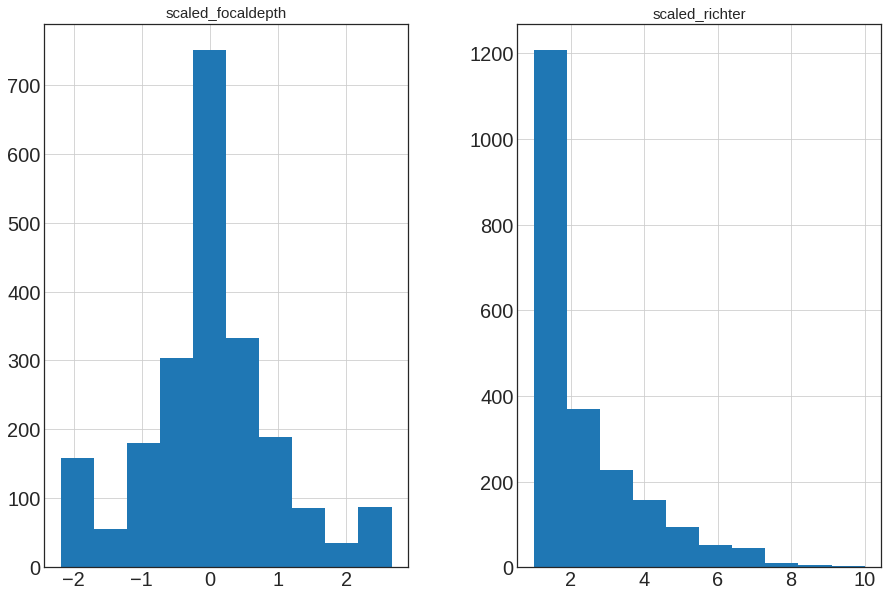

In [ ]:
minmax = MinMaxScaler(feature_range=(1, 10))
powertrans = PowerTransformer()
df.loc[:, 'scaled_focaldepth'] =  powertrans.fit_transform(df['Focal depth'].to_frame())
df.loc[:, 'scaled_richter'] =  minmax.fit_transform(df['Richter'].to_frame())
df[['scaled_focaldepth', 'scaled_richter']].hist(figsize=(15, 10));

## Scatterplots

This figure allows us to see the geographical representation of data.

In [ ]:
fig = px.scatter(df, x='Longitude', y='Latitude', color='scaled_focaldepth', size='scaled_richter', size_max=12)
fig.update_layout(title='Earthquakes scatterplot; color -> scaled_focaldepth; size -> scaled_richter')
fig.show()

In [ ]:
fig = px.scatter(df, x='Longitude', y='Latitude', color='Focal depth')
fig.update_layout(title='Earthquakes scatterplot; color -> Focal depth')
fig.show()

Some insights:

* Earthquakes with the highest Focal depth mainly can be seen near to the most noticable geographical clusters and are often located at the borders of them. 

In [ ]:
fig = px.scatter(df, x='Longitude', y='Latitude', color='Richter')
fig.update_layout(title='Earthquakes scatterplot; color -> Richter')
fig.show()

Powerful earthquakes (Richter) are scattered around the graph, in comparison to deep earthquakes (Focal depth), which can be seen mainly at specific areas.

## Map

In [ ]:
fig = px.scatter_geo(df, lon='Longitude', lat='Latitude', color='Focal depth', size='scaled_richter', size_max=13, height=700, width=1400)
fig.update_layout( 
    title={
        'text': "Earthquakes map",
        'y': 0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
        )
fig.show()

Some insights:

* Most of the earthquakes are located at the coastal regions.

# 5. Clustering

Here we will use 3 different algorithms of clustering: KMeans, Agglomerative clustering and DBSCAN. Baseline - KMeans.

It is not quite obvious, what results we need to achieve. There are some assumtions about what we want to find in our data:

1. Clusters, related to different regions;

2. Clusters of similar types of earthquakes;

3. We can try to encode coordinates using clustering (for example, like in 1) and than add it as a new feature.

Probably, we can make 2 steps: divide data into clusters like in step 1 using coordinates (find different regions), than, using other features, divide earthquakes into groups. Finaly we will get information about location and type of earthquakes (location, type).

We will use method 3.


In [ ]:
df.drop(['scaled_focaldepth', 'scaled_richter'], inplace=True, axis=1)

## Geo clusters

Firstly we will try to divide earthquakes only by locations. We will use results as an input for further clustering.

Before using lon/lat, we should preprocess it, because this format is not the most appropriate for our task.

In [ ]:
coord_fixed = pd.DataFrame()

lat = np.radians(df['Latitude'])
lon = np.radians(df['Longitude'])
coord_fixed['x'] = np.cos(lat) * np.cos(lon)
coord_fixed['y'] = np.cos(lat) * np.sin(lon)
coord_fixed['z'] = np.sin(lat)

In [ ]:
std = StandardScaler()
X = std.fit_transform(coord_fixed)

In [ ]:
def plot_silhoette(model, X, n_clust_range=(2, 5), step=1):
    for n_clusters in range(n_clust_range[0], n_clust_range[1]):

        fig, ax1 = plt.subplots(1, 1)
        fig.set_size_inches(18, 7)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        clusterer = model(n_clusters=n_clusters, random_state=0)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters, \
              "The average silhouette_score is :", silhouette_avg)

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                    "with n_clusters = %d" % n_clusters),
                    fontsize=14, fontweight='bold')

    plt.show()

def print_silhoette(model, X, n_clust_range=(2, 8), step=1):
    for n_clusters in range(n_clust_range[0], n_clust_range[1], step):
        clusterer = model(n_clusters=n_clusters, random_state=0)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters, \
              "The average silhouette_score is :", silhouette_avg)
        

def plot_silhoette_scores(model, X, n_clust_range=(2, 20), step=1):
    silh_scores = []
    for n_clusters in range(n_clust_range[0], n_clust_range[1], step):
        clusterer = model(n_clusters=n_clusters, random_state=0)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        silh_scores.append(silhouette_avg)
        print("For n_clusters =", n_clusters, \
              "The average silhouette_score is :", silhouette_avg)
    plt.xlabel('number of clusters')
    plt.ylabel('silhouette score')
    plt.plot(range(n_clust_range[0], n_clust_range[1], step), silh_scores)
    plt.scatter(range(n_clust_range[0], n_clust_range[1], step), silh_scores)
    plt.grid()
    plt.show()
        

We will use silhoette scores to asses model.

For n_clusters = 2 The average silhouette_score is : 0.4708240590235657
For n_clusters = 3 The average silhouette_score is : 0.4654184267711821
For n_clusters = 4 The average silhouette_score is : 0.49489961669678534
For n_clusters = 5 The average silhouette_score is : 0.5102591496559877
For n_clusters = 6 The average silhouette_score is : 0.49800399579041965
For n_clusters = 7 The average silhouette_score is : 0.4881612787131221
For n_clusters = 8 The average silhouette_score is : 0.4831239443579618
For n_clusters = 9 The average silhouette_score is : 0.4927734417415222
For n_clusters = 10 The average silhouette_score is : 0.4979375579148141
For n_clusters = 11 The average silhouette_score is : 0.5027188860023168
For n_clusters = 12 The average silhouette_score is : 0.501479607865665
For n_clusters = 13 The average silhouette_score is : 0.49125509649283733
For n_clusters = 14 The average silhouette_score is : 0.48493507206489034
For n_clusters = 15 The average silhouette_score is : 0.

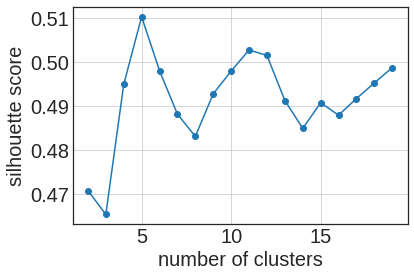

In [ ]:
plot_silhoette_scores(KMeans, X, )

Algorithm gives the highest score for n_clusters = 5. We will visualize.

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
y_kmeans = kmeans.fit_predict(X)

In [ ]:
fig = px.scatter_geo(df, lon='Longitude', lat='Latitude', color=y_kmeans, hover_data=['Richter', 'Focal depth'])
fig.update_layout(title='Earthquakes scatterplot with cluster numbers')
fig.show()

As we can see, k_means showed enough good clusterization. Using these labels we can bound earthquakes to specific areas.

In [ ]:
silhouette_avg = silhouette_score(X, y_kmeans)
silhouette_avg

0.5101372980893721

In [ ]:
df_ = df.drop(['Latitude', 'Longitude'], axis=1)
df_.loc[:, 'geo_clusters'] = y_kmeans

## KMeans

Before using clustering methods, we should perform data preparation.

In [ ]:
pipe_geo = Pipeline([
    ('ohe', OneHotEncoder(sparse=False))
])

pipe_fdepth = Pipeline([
    ('pow', PowerTransformer()), 
])

pipe_rich = Pipeline([
    ('std', StandardScaler()), 
])

pipe = ColumnTransformer(transformers=[
    ('geo', pipe_geo, ['geo_clusters']),
    ('fdepth', pipe_fdepth,  ['Focal depth']),
    ('rich', pipe_rich,  ['Richter']),
], verbose=False)

In [ ]:
df_scaled = pipe.fit_transform(df_)

Let's look KMeans works with 15 clusters.

In [ ]:
kmeans = KMeans(n_clusters=15, random_state=42)
y_kmeans = kmeans.fit_predict(df_scaled)
silhouette_avg = silhouette_score(df_scaled, y_kmeans)
silhouette_avg

0.36531478631971714

Now, we can try to find the optimal number of clusters. 

For n_clusters = 2 The average silhouette_score is : 0.2845756119750338
For n_clusters = 7 The average silhouette_score is : 0.3507426688323239
For n_clusters = 12 The average silhouette_score is : 0.3708896713954001
For n_clusters = 17 The average silhouette_score is : 0.35958393783952664
For n_clusters = 22 The average silhouette_score is : 0.3754437437222345
For n_clusters = 27 The average silhouette_score is : 0.38094575250643015
For n_clusters = 32 The average silhouette_score is : 0.3810701757922216
For n_clusters = 37 The average silhouette_score is : 0.4015246626875023
For n_clusters = 42 The average silhouette_score is : 0.3936014407468266
For n_clusters = 47 The average silhouette_score is : 0.4006059394884963
For n_clusters = 52 The average silhouette_score is : 0.4125625955848272
For n_clusters = 57 The average silhouette_score is : 0.42676199541995635
For n_clusters = 62 The average silhouette_score is : 0.4297535439908763
For n_clusters = 67 The average silhouette_score i

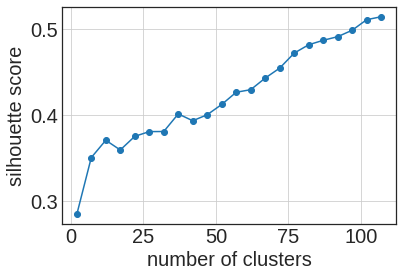

In [ ]:
plot_silhoette_scores(KMeans, df_scaled, n_clust_range=(2, 110), step=5)

For n_clusters = 50 The average silhouette_score is : 0.4108853298300263
For n_clusters = 100 The average silhouette_score is : 0.5104613812703518
For n_clusters = 150 The average silhouette_score is : 0.5516737050586025
For n_clusters = 200 The average silhouette_score is : 0.570741817691114
For n_clusters = 250 The average silhouette_score is : 0.5874561729258195
For n_clusters = 300 The average silhouette_score is : 0.600715690364589
For n_clusters = 350 The average silhouette_score is : 0.6082457182077883
For n_clusters = 400 The average silhouette_score is : 0.6104419167376431
For n_clusters = 450 The average silhouette_score is : 0.6131171343333137
For n_clusters = 500 The average silhouette_score is : 0.6116165123929044
For n_clusters = 550 The average silhouette_score is : 0.6138044497296193
For n_clusters = 600 The average silhouette_score is : 0.617477508151798
For n_clusters = 650 The average silhouette_score is : 0.6115220485766513
For n_clusters = 700 The average silhouett

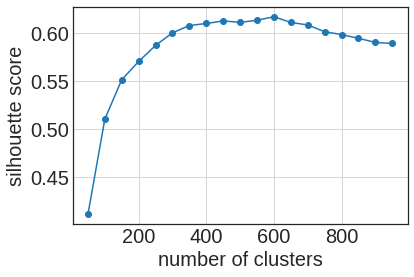

In [ ]:
plot_silhoette_scores(KMeans, df_scaled, n_clust_range=(50, 951), step=50)

According to that graph, the optimal value is near to 600. But our dataset contains only about 2000 sample. And, probably, we don't need to get so many clusters. Let's choose 100 cluster, where the score starts to outweigh 0.5.

In [ ]:
kmeans = KMeans(n_clusters=100, random_state=42)
y_kmeans = kmeans.fit_predict(df_scaled)

fig = px.scatter_geo(df, lon='Longitude', lat='Latitude', color=y_kmeans, hover_data=['Richter', 'Focal depth'])
fig.update_layout(title='Earthquakes scatterplot with cluster numbers')
fig.show()

## DBSCAN

In [ ]:
epsilon_param_options = np.arange(0.001, 6, 0.02)
min_samples_param_options = np.arange(2, df_scaled.shape[1]+1, 1)
param_grid = itertools.product(epsilon_param_options, min_samples_param_options)

print('Amount of hyperparameters combinations: {}'.format(len(epsilon_param_options) * len(min_samples_param_options)))

Amount of hyperparameters combinations: 1800


In [ ]:
params_dict = {}

for param_set in tqdm(param_grid, total=len(epsilon_param_options) * len(min_samples_param_options)):
  dbscan = DBSCAN(eps=param_set[0], min_samples=param_set[1])

  y_dbscan = dbscan.fit_predict(df_scaled)

  if len(set(y_dbscan) - set([-1])) == len(set(y_kmeans)):
    params_dict['{}_{}_{}'.format(len(set(y_dbscan) - set([-1])), param_set[0], param_set[1])] = (param_set, 
                                                                                                  silhouette_score(df_scaled, y_dbscan),
                                                                                                  adjusted_mutual_info_score(y_kmeans, y_dbscan))

  0%|          | 0/1800 [00:00<?, ?it/s]

In [ ]:
params_dict

{'100_0.161_3': ((0.161, 3), 0.2523105040367912, 0.7635626496852835)}

The silhouette score is two time less than for KMeans, but adjusted_mutual_info_score, built using KMeans is enough good.

In [ ]:
 dbscan = DBSCAN(eps=0.161, min_samples=3)
 y_dbscan = dbscan.fit_predict(df_scaled)

fig = px.scatter_geo(df, lon='Longitude', lat='Latitude', color=y_dbscan, hover_data=['Richter', 'Focal depth'])
fig.update_layout(title='Earthquakes scatterplot with cluster numbers')
fig.show()

## Agglomerative clustering

In [ ]:
linkage_param_options = ['ward', 'complete', 'average', 'single']
param_grid = itertools.product(linkage_param_options)

print('Amount of hyperparameters combinations: {}'.format(len(linkage_param_options)))

Amount of hyperparameters combinations: 4


In [ ]:
params_dict = {}

for param_set in tqdm(param_grid, total=len(linkage_param_options)):

  agg = AgglomerativeClustering(n_clusters=len(set(y_kmeans)),linkage=param_set[0])
  y_agg = agg.fit_predict(df_scaled)

  params_dict['{}'.format(param_set[0])] = (param_set,
                                          silhouette_score(df_scaled, y_agg),
                                          adjusted_mutual_info_score(y_kmeans, y_agg))

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
params_dict

{'average': (('average',), 0.42308742910808916, 0.8246103819376113),
 'complete': (('complete',), 0.374243879669791, 0.7971002473105745),
 'single': (('single',), 0.14514503307357898, 0.712305139590437),
 'ward': (('ward',), 0.491397597047795, 0.8774606858473676)}

We can see, that silhouette_score is close to the score of KMeans, and adjusted_mutual_info_score is also enough good.

In [ ]:
agglomerative = AgglomerativeClustering(n_clusters=len(set(y_kmeans)), linkage='ward')

In [ ]:
y_agglomerative = agglomerative.fit_predict(df_scaled)

In [ ]:
fig = px.scatter_geo(df, lon='Longitude', lat='Latitude', color=y_agglomerative, hover_data=['Richter', 'Focal depth'])
fig.update_layout(title='Red wine sorts in 2d PCA space (Agglomerative clustering labels)')
fig.show()

# Results analysis

So, we got the final results for our algorithms, and KMeans showed the best results. Let's analyse kmeans output clusters.

In [ ]:
data = df.copy(deep=True)
data['label'] = y_kmeans
data

,Focal depth,Latitude,Longitude,Richter,label
0,33,-52.26,28.30,6.7,85
1,36,45.53,150.93,5.8,88
2,57,41.85,142.78,5.8,88
3,67,29.19,141.15,6.2,10
4,30,-21.66,169.81,6.0,24
...,...,...,...,...,...
2173,13,51.54,-173.11,5.8,23
2174,97,-10.16,161.01,5.9,41
2175,527,27.87,139.51,5.8,50
2176,51,36.43,140.98,6.0,53


Firstly, let's look at some close dots. 

In [ ]:
fig = px.scatter_geo(data, 
                     lon='Longitude', lat='Latitude', color='label', hover_data=['Richter', 'Focal depth'])
fig.update_layout(title='Earthquakes scatterplot with cluster numbers')
fig.show()

In [ ]:
fig = px.scatter_geo(data[(data['label'] == 73) | (data['label'] == 43) | (data['label'] == 2)| (data['label'] == 30)], 
                     lon='Longitude', lat='Latitude', color='label', hover_data=['Richter', 'Focal depth'])
fig.update_layout(title='Earthquakes scatterplot with cluster numbers')
fig.show()

Some insights:

* We can see, that dots are located at the same area, which was defined by KMeans algorithms using coordinates. 

* Different clusters have different characteristics. For example, red dots have large Focal depth, violet dots have large richter and small Focal depth.


Let's check some characteristics of our clusters.

In [ ]:
iqr = lambda x: np.subtract(*np.percentile(x, [75, 25]))

In [ ]:
d = data.groupby('label').agg({'Focal depth' : ['min', 'max', 'median', iqr, 'count'], 'Richter' :  ['min', 'max', 'median', iqr, 'count']})
d

Focal depth                         ... Richter                        
              min  max median <lambda_0>  ...     max median <lambda_0> count
label                                     ...                                
0              27   77   47.5      25.25  ...     6.1    6.1        0.0    24
1              10   29   16.5       8.75  ...     6.0    5.9        0.0    26
2              68  200  100.0      25.25  ...     5.8    5.8        0.0    32
3               0    3    0.0       0.00  ...     6.0    6.0        0.0    27
4              16   50   38.0      21.00  ...     6.6    6.5        0.0    13
...           ...  ...    ...        ...  ...     ...    ...        ...   ...
95             52  181   99.0      23.50  ...     6.4    6.3        0.0    11
96             10   27   21.0       6.75  ...     5.8    5.8        0.0    20
97              9   29   15.0      12.00  ...     6.4    6.3        0.1    11
98            190  210  205.0      12.00  ...     6.4    6.3        0.1     5
99              0    4    0.0       2.00  ...     6.5    6.5        0.0     3

[100 rows x 10 columns]

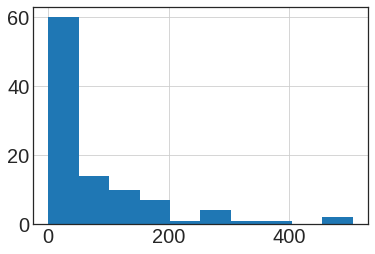

In [ ]:
(d['Focal depth']['max'] - d['Focal depth']['min']).hist();

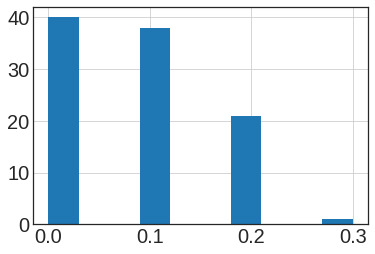

In [ ]:
(d['Richter']['max'] - d['Richter']['min']).hist();

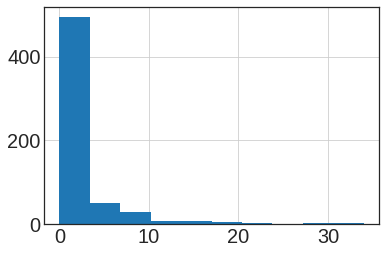

In [ ]:
d['Focal depth']['<lambda_0>'].hist();

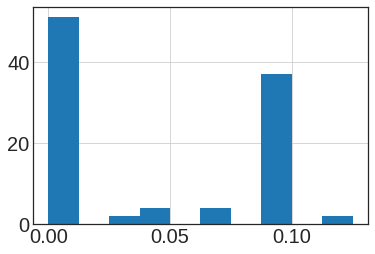

In [ ]:
d['Richter']['<lambda_0>'].hist();

Some insights:

* Interquartile range is pretty small for cluster.

* It seems, that algorithm enough good divides earthquakes by their characteristics. 

# Conclusion




In this work we:

* Carried out EDA and found some patterns in data. 

* Analysed distributions and applied appropriate preprocessing.

* We used three types of clustering algorithms. The best - KMeans, the worst - DBSCAN (for our data).

* Analysed clusters and found patterns in clustering (found different types of earthquakes for different locations). 